## Assigment: Neural network basics

Soft deadline: 16.09.18 at 23.59

Hard deadline: 18.09.18 at 23.59

For this task I intentionally provide no boilerplate code, because very puprpose of this task is getting you comforatable with basic code template for desiging NNs in pytorch. I higly recommend you to revisit all the last seminar materials.

#### Task

* Implement simple **fully-convolutional** neural architecture for classification. Make sure it is small enought to run on your home machine.
* Provide dataset visulization.
* Provide train/test split and validation

#### Requirements

* Architecture should derive from `torch.nn.Module`
* Use `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`. But if you manage co simplify this step using dataset `torchivision`, I will only encourage you.
* Implement at least one data transformer, but make sure it is useful for classification task.
* Use FashionMNIST dataset https://github.com/zalandoresearch/fashion-mnist
* Make sure you can fix random seed for all components of your code to make experiments reproducible
* Since you architecure should be fully-convolutional, make sure it does not depend on input size.

In [1]:
import torch
from torchvision import datasets, transforms
import time

trf = transforms.Compose([transforms.ToTensor()])
transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=trf)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=True)

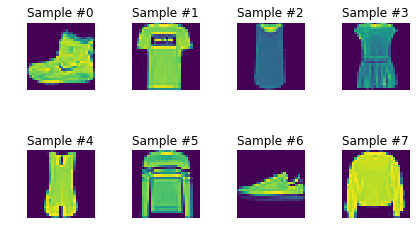

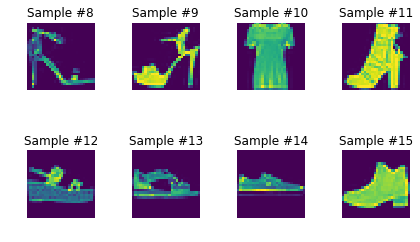

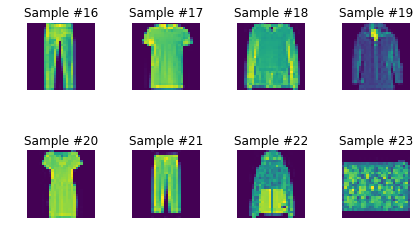

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure()

for i in range(len(trainset)):
    sample = trainset[i]


    ax = plt.subplot(2, 4, (i % 8) + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample[0][0])

    if i % 8 == 7:
        plt.show()
    if i == 23:
        break

In [ ]:
%%time

class ConvNet(torch.nn.Module):
    def __init__(self, img_size, img_chanels, num_cls):
        size_1 = 16
        size_2 = 64
        super(ConvNet, self).__init__()
        self.layer1 = torch.nn.Conv2d(img_chanels, size_1, 3, padding=1)
        self.norm1 = torch.nn.BatchNorm2d(size_1)
        self.layer2 = torch.nn.Conv2d(size_1, size_2, 3, padding = 1)
        self.norm2 = torch.nn.BatchNorm2d(size_2)
        self.layer3 = torch.nn.Conv2d(size_2, size_2, 3, padding = 1)
        self.norm3 = torch.nn.BatchNorm2d(size_2)
        self.layer4 = torch.nn.Conv2d(size_2, size_2, 5)
        self.norm4 = torch.nn.BatchNorm2d(size_2)
        self.layer5 = torch.nn.MaxPool2d(2)#torch.nn.Conv2d(size_2, size_2, 5)
        self.norm5 = torch.nn.BatchNorm2d(size_2)
        self.layer6 = torch.nn.Conv2d(size_2, size_2, 5)
        self.norm6 = torch.nn.BatchNorm2d(size_2)
        self.layer7 = torch.nn.Conv2d(size_2, size_2, 5)
        self.norm7 = torch.nn.BatchNorm2d(size_2)
        self.layer_z = torch.nn.Conv2d(size_2, 8, 1)
        self.norm_z = torch.nn.BatchNorm2d(8)
        self.layer_f = torch.nn.Linear(128, 120)
        self.layer_s = torch.nn.Linear(120, num_cls)
        
        self.img_size = img_size
        
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x_1 = self.norm1(self.relu(self.layer1(x)))
        x_2 = self.norm2(self.relu(self.layer2(x_1)))
        x_3 = self.norm3(self.relu(self.layer3(x_2)))
        x_4 = self.norm4(self.relu(self.layer4(x_3)))
        x_5 = self.norm5(self.relu(self.layer5(x_4)))
        x_6 = self.norm6(self.relu(self.layer6(x_5)))
        x_z = self.norm7(self.relu(self.layer7(x_6)))
        x_t = self.norm_z(self.relu(self.layer_z(x_z)))
        x_p = x_t.view(x_t.shape[0],x_t.shape[1]*x_t.shape[2]*x_t.shape[3])
#         self.linear = torch.nn.Linear(x_4.shape[0], 120)
        x_rs = self.relu(self.layer_f(x_p))
        y_pred = torch.nn.Softmax(dim=1)(self.layer_s(x_rs))
        return y_pred

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model = ConvNet([28, 28], 1, 10)


model.to(device)


criterion = torch.nn.MSELoss()
learning_rate = 0.1
epoch = 5
loss_r = np.zeros(epoch)
plt.figure(figsize=(12,5))

for i in range(epoch):
    for data, target in trainloader:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        learning_rate *= 0.9999
        t = data.to(device)
        y_pred = model(t)
        y = torch.zeros(t.shape[0], 10)
        arr = torch.arange(t.shape[0])
        y[arr,target] = 1.0
        y = y.to(device)
        loss = criterion(y_pred, y)
        loss_r[i] = loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    visualize(loss.item(), i)
visualize(loss_r.item(), epoch)
    


In [ ]:
count_fl = len(testset)
count_ok = 0
t = 0
for data, target in testloader:
    t = data.to(device)
    y_pred = model(t)
    res = torch.argmax(y_pred, dim=1)

    target = target.to(device)

    count_ok += torch.sum(res==target).item()

In [ ]:
print(count_ok/count_fl)